In [52]:
#apertura del dataset
import pandas as pd

df = pd.read_csv('../datasets/Grocery_Inventory new v1.csv')
df.head(5)

,Product_Name,Category,Supplier_Name,Warehouse_Location,Status,Product_ID,Supplier_ID,Date_Received,Last_Order_Date,Expiration_Date,Stock_Quantity,Reorder_Level,Reorder_Quantity,Unit_Price,Sales_Volume,Inventory_Turnover_Rate,percentage
0,Bell Pepper,Fruits & Vegetables,Eimbee,20 Pennsylvania Parkway,Discontinued,29-017-6255,43-348-2450,3/1/2024,1/6/2025,1/31/2025,46,64,17,$4.60,96,55,1.96%
1,Vegetable Oil,Oils & Fats,Digitube,03643 Oakridge Lane,Backordered,79-569-8856,04-854-7165,4/1/2024,5/19/2024,6/11/2024,51,87,86,$2.00,24,83,0.91%
2,Parmesan Cheese,Dairy,BlogXS,73 Graedel Street,Discontinued,28-146-2641,82-995-0739,4/1/2024,12/21/2024,4/8/2024,38,67,66,$12.00,35,24,1.36%
3,Carrot,Fruits & Vegetables,Avaveo,44801 Myrtle Center,Discontinued,11-581-9869,22-867-3079,5/1/2024,12/12/2024,9/26/2024,51,60,98,$1.50,44,95,1.36%
4,Garlic,Fruits & Vegetables,Katz,6195 Monterey Center,Discontinued,13-202-4809,24-281-7685,5/1/2024,7/28/2024,5/20/2024,27,22,89,$7.00,91,77,2.17%


In [ ]:
df_products = df[['Product_Name', 'Category', 'Date_Received', 'Expiration_Date']]
df_products = df_products.rename(columns={'Product_Name': 'productos',
                    'Category': 'categoria',
                    'Date_Received':'fecha_recibido',
                    'Expiration_Date': 'fecha_expiracion'})

#Modificacion de la columna fecha de recibido a tipo de dato fecha
df_products['fecha_recibido'] = pd.to_datetime( df_products['fecha_recibido'] , format='%m/%d/%Y')

#Modificacion de la columna fecha de vencimiento a tipo de dato fecha
df_products['fecha_expiracion'] = pd.to_datetime( df_products['fecha_expiracion'] , format='%m/%d/%Y')

#Ahora se calcula el tiempo en dias de vida uitl del producto (Desde que se recibio)
df_products['vida_util_restante(dias)'] = (df_products['fecha_expiracion'] - df_products['fecha_recibido']).dt.days

'''El dataset contiene productos que ya han caducado y para el modelo de ML no es util, pues no define su naturelaza de ser perecedero o no perecedero
Por lo que los productos caducados se eliminaran del dataset
'''
df_products = df_products[df_products['vida_util_restante(dias)'] > 0]


df_products

,productos,categoria,fecha_recibido,fecha_expiracion,vida_util_restante(dias)
0,Bell Pepper,Fruits & Vegetables,2024-03-01,2025-01-31,336
1,Vegetable Oil,Oils & Fats,2024-04-01,2024-06-11,71
2,Parmesan Cheese,Dairy,2024-04-01,2024-04-08,7
3,Carrot,Fruits & Vegetables,2024-05-01,2024-09-26,148
4,Garlic,Fruits & Vegetables,2024-05-01,2024-05-20,19
...,...,...,...,...,...
975,Blueberries,Fruits & Vegetables,2024-09-23,2024-12-20,88
976,Peanut Oil,Oils & Fats,2024-09-23,2024-11-27,65
979,Tuna,Seafood,2024-09-24,2024-10-15,21
983,Feta Cheese,Dairy,2024-09-27,2025-02-06,132


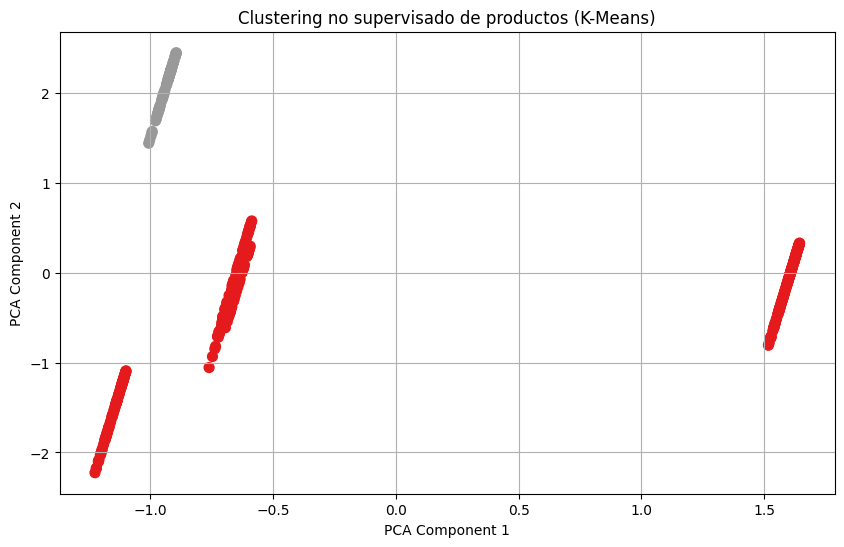

In [80]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Supongamos que df_products ya tiene:
# 'productos', 'categoria', 'vida_util_restante(dias)'

# --- 1. One-hot encoding de categoría ---
df_encoded = pd.get_dummies(df_products['categoria'])

# Añadir la vida útil restante como feature numérico
df_encoded['vida_util_restante'] = df_products['vida_util_restante(dias)']

# --- 2. Escalar los features ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_encoded)

# --- 3. Aplicar K-Means con 2 clusters ---
kmeans = KMeans(n_clusters=2, random_state=42)
df_products['cluster'] = kmeans.fit_predict(X_scaled)

# --- 4. Reducir a 2D para graficar ---
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# --- 5. Graficar los clusters ---
plt.figure(figsize=(10,6))
plt.scatter(X_pca[:,0], X_pca[:,1], c=df_products['cluster'], cmap='Set1', s=50)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('Clustering no supervisado de productos (K-Means)')
plt.grid(True)
plt.show()


In [81]:
# Mostrar productos en cada cluster
cluster_0 = df_products[df_products['cluster']==0]['productos']
cluster_1 = df_products[df_products['cluster']==1]['productos']

print("Cluster 0:\n", cluster_0.head(10))
print("\nCluster 1:\n", cluster_1.head(10))


Cluster 0:
 0         Bell Pepper
1       Vegetable Oil
2     Parmesan Cheese
3              Carrot
4              Garlic
5               Lemon
7           Anchovies
9              Yogurt
10     Cheddar Cheese
11        Avocado Oil
Name: productos, dtype: object

Cluster 1:
 24         Jasmine Rice
29         Arborio Rice
30          Bread Flour
35           Rice Flour
50    Whole Wheat Flour
53         Jasmine Rice
63           Sushi Rice
64           Black Rice
66            Wild Rice
68           Black Rice
Name: productos, dtype: object


In [ ]:
df_products[df_products['productos'] == 'Yogurt']

,productos,categoria,fecha_recibido,fecha_expiracion,vida_util_restante(dias),cluster
9,Yogurt,Dairy,2024-06-01,2024-10-25,146,0
102,Yogurt,Dairy,2024-04-05,2025-02-02,303,0
790,Yogurt,Dairy,2024-06-15,2025-02-01,231,0
